In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#### Подготовка данных
Переводим в тензор и и произодим нормализацию в диапазон [−1,1] (для функции активации tanh).

100%|██████████| 170M/170M [00:02<00:00, 75.3MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


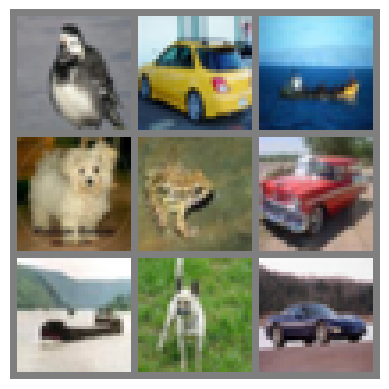

In [4]:
# Определяем преобразования: перевод в тензор и нормализация.
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загружаем датасет CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Функция для визуализации изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация к диапазону [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Просмотр нескольких изображений из обучающей выборки
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(utils.make_grid(images[:9], nrow=3))


### GAN на основе полносвязных слоёв 

In [5]:
# Определение генератора для GAN 
class GeneratorFC(nn.Module):
    def __init__(self, nz=100, ngf=256, nc=3):
        super(GeneratorFC, self).__init__()
        self.nc = nc
        self.main = nn.Sequential(
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf * 2),
            nn.ReLU(True),
            nn.Linear(ngf * 2, 32 * 32 * nc),
            nn.Tanh()  # Выход в диапазоне [-1, 1]
        )
    
    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, self.nc, 32, 32)
        return output

# Определение дискриминатора для GAN 
class DiscriminatorFC(nn.Module):
    def __init__(self, nc=3, ndf=256):
        super(DiscriminatorFC, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(32 * 32 * nc, ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf * 2, ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(ndf, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        input_flat = input.view(input.size(0), -1)
        return self.main(input_flat)

cuda
Epoch [1/50] Loss_D: 0.3532 Loss_G: 2.4731
Epoch [2/50] Loss_D: 0.1585 Loss_G: 7.3595
Epoch [3/50] Loss_D: 0.1453 Loss_G: 7.6491
Epoch [4/50] Loss_D: 0.2025 Loss_G: 5.6247
Epoch [5/50] Loss_D: 0.3359 Loss_G: 4.6465
Epoch [6/50] Loss_D: 0.4128 Loss_G: 4.7282
Epoch [7/50] Loss_D: 0.4551 Loss_G: 4.6965
Epoch [8/50] Loss_D: 0.5139 Loss_G: 3.9626
Epoch [9/50] Loss_D: 0.5621 Loss_G: 3.7506
Epoch [10/50] Loss_D: 0.5665 Loss_G: 3.5842
Epoch [11/50] Loss_D: 0.6083 Loss_G: 3.1258
Epoch [12/50] Loss_D: 0.6571 Loss_G: 3.0067
Epoch [13/50] Loss_D: 0.7188 Loss_G: 2.7912
Epoch [14/50] Loss_D: 0.7043 Loss_G: 2.7202
Epoch [15/50] Loss_D: 0.7137 Loss_G: 2.9014
Epoch [16/50] Loss_D: 0.7701 Loss_G: 2.6212
Epoch [17/50] Loss_D: 0.7759 Loss_G: 2.5294
Epoch [18/50] Loss_D: 0.7959 Loss_G: 2.4300
Epoch [19/50] Loss_D: 0.8114 Loss_G: 2.3605
Epoch [20/50] Loss_D: 0.8589 Loss_G: 2.3621
Epoch [21/50] Loss_D: 0.8604 Loss_G: 2.2191
Epoch [22/50] Loss_D: 0.8916 Loss_G: 2.1832
Epoch [23/50] Loss_D: 0.8838 Loss_G:

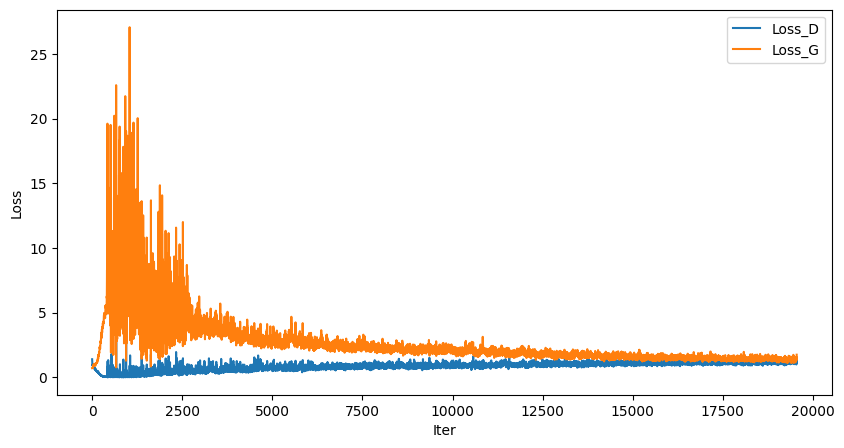

In [6]:
# Устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Гиперпараметры
nz = 100      # Размер латентного вектора
ngf = 256     # Число нейронов в генераторе
ndf = 256     # Число нейронов в дискриминаторе
nc = 3        # Количество каналов (RGB)
lr = 0.0002
beta1 = 0.5
num_epochs = 50
batch_size = 128

# Инициализация моделей
netGG = GeneratorFC(nz, ngf, nc).to(device)
netDG = DiscriminatorFC(nc, ndf).to(device)

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()
optimizerD = optim.Adam(netDG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netGG.parameters(), lr=lr, betas=(beta1, 0.999))

# Списки для сохранения значений loss по эпохам и по итерациям
epoch_losses_D = []
epoch_losses_G = []
iter_losses_D = []
iter_losses_G = []

# Фиксированный шум для генерации изображений
fixed_noise = torch.randn(64, nz, device=device)

global_iter = 0
for epoch in range(num_epochs):
    running_loss_D = 0.0
    running_loss_G = 0.0
    for i, (data, _) in enumerate(train_loader):
        b_size = data.size(0)
        real_images = data.to(device)
        # Исправленные метки с размерностью (b_size, 1)
        labels_real = torch.full((b_size, 1), 1.0, device=device)
        labels_fake = torch.full((b_size, 1), 0.0, device=device)
        
        ## Обучение дискриминатора
        netDG.zero_grad()
        output_real = netDG(real_images)
        lossD_real = criterion(output_real, labels_real)
        lossD_real.backward()
        
        noise = torch.randn(b_size, nz, device=device)
        fake_images = netGG(noise)
        output_fake = netDG(fake_images.detach())
        lossD_fake = criterion(output_fake, labels_fake)
        lossD_fake.backward()
        
        lossD = lossD_real + lossD_fake
        optimizerD.step()
        
        ## Обучение генератора
        netGG.zero_grad()
        output_gen = netDG(fake_images)
        lossG = criterion(output_gen, labels_real)  # Цель генератора – обмануть дискриминатор
        lossG.backward()
        optimizerG.step()
        
        running_loss_D += lossD.item()
        running_loss_G += lossG.item()
        
        # Сохраняем значения loss для каждой итерации
        iter_losses_D.append(lossD.item())
        iter_losses_G.append(lossG.item())
        global_iter += 1
        
    avg_loss_D = running_loss_D / len(train_loader)
    avg_loss_G = running_loss_G / len(train_loader)
    epoch_losses_D.append(avg_loss_D)
    epoch_losses_G.append(avg_loss_G)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {avg_loss_D:.4f} Loss_G: {avg_loss_G:.4f}")
    


plt.figure(figsize=(10, 5))
plt.plot(iter_losses_D, label="Loss_D")
plt.plot(iter_losses_G, label="Loss_G")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Генерация изображений с помощью GAN

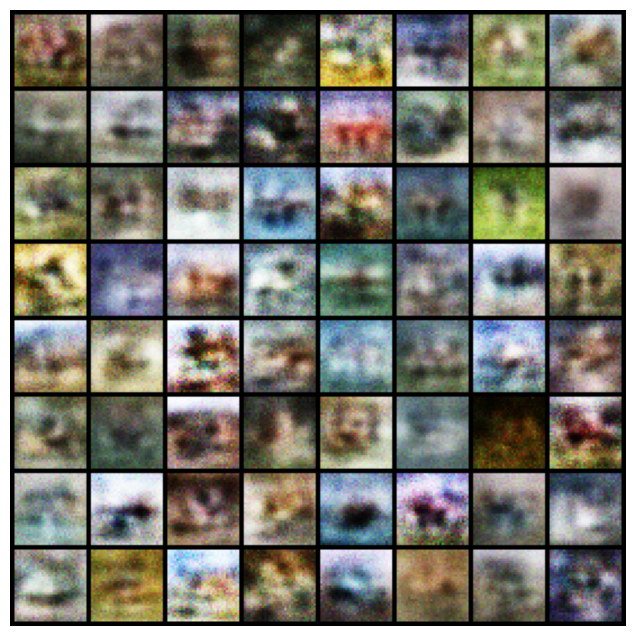

In [7]:
# Генерация изображений с помощью обученного генератора
netGG.eval()  # Перевод модели в режим оценки
with torch.no_grad():
    noise = torch.randn(64, nz, device=device)
    generated_images = netGG(noise).detach().cpu()

grid = torchvision.utils.make_grid(generated_images, padding=2, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()

In [11]:
from torchvision.models import inception_v3
import torch.nn.functional as F


def get_inception_score(images, splits=10):    
    # Изменяем размер изображений до 299x299, как требуется для inception_v3
    up = torch.nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False)
    images_resized = up(images)
    
    # Загружаем предобученную модель Inception v3
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    
    preds = []
    batch_size_inception = 32
    with torch.no_grad():
        for i in range(0, images_resized.size(0), batch_size_inception):
            batch = images_resized[i:i+batch_size_inception].to(device)
            logits = inception_model(batch)
            # Если модель возвращает кортеж, используем первый элемент (логиты)
            if isinstance(logits, tuple):
                logits = logits[0]
            preds.append(F.softmax(logits, dim=1).cpu())
    preds = torch.cat(preds, dim=0)
    
    # Расчёт Inception Score
    scores = []
    N = preds.size(0)
    split_size = N // splits
    for i in range(splits):
        part = preds[i * split_size:(i+1) * split_size, :]
        p_y = torch.mean(part, dim=0, keepdim=True)
        kl_div = part * (torch.log(part) - torch.log(p_y))
        kl_div = torch.mean(torch.sum(kl_div, dim=1))
        scores.append(torch.exp(kl_div).item())
    return np.mean(scores), np.std(scores)

# Для Inception Score необходимо, чтобы изображения были в диапазоне [0, 1]
# Преобразуем сгенерированные изображения из диапазона [-1, 1] в [0, 1]
generated_images_01 = (generated_images + 1) / 2.0

mean_is, std_is = get_inception_score(generated_images_01, splits=10)
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Inception Score: 1.4151 ± 0.1410


### DCGAN на основе свёрточных слоёв

In [12]:
# Определение генератора для DCGAN 
class GeneratorDCGAN(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3, ngpu=1):
        super(GeneratorDCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Преобразование латентного вектора в тензор размера (ngf*8, 4, 4)
            nn.Linear(nz, ngf * 8 * 4 * 4),
            nn.BatchNorm1d(ngf * 8 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (ngf * 8, 4, 4)),
            # Транспонированные свёртки для увеличения размеров
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),      # 16x16 -> 32x32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.Conv2d(ngf, nc, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()  # Выход в диапазоне [-1, 1]
        )
    
    def forward(self, input):
        return self.main(input)

# Определение дискриминатора для DCGAN с поддержкой нескольких GPU
class DiscriminatorDCGAN(nn.Module):
    def __init__(self, nc=3, ndf=64, ngpu=1):
        super(DiscriminatorDCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),   # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 8x8
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 4x4
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),   # 4x4 -> 1x1
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

cuda
Epoch [1/20] Loss_D: 0.7871 Loss_G: 3.0969
Epoch [2/20] Loss_D: 0.7448 Loss_G: 2.8469
Epoch [3/20] Loss_D: 0.8576 Loss_G: 2.5024
Epoch [4/20] Loss_D: 1.0421 Loss_G: 1.9356
Epoch [5/20] Loss_D: 0.9101 Loss_G: 2.0595
Epoch [6/20] Loss_D: 0.8494 Loss_G: 2.2379
Epoch [7/20] Loss_D: 0.8937 Loss_G: 2.0970
Epoch [8/20] Loss_D: 1.0138 Loss_G: 1.8402
Epoch [9/20] Loss_D: 1.0210 Loss_G: 1.7544
Epoch [10/20] Loss_D: 1.0347 Loss_G: 1.7382
Epoch [11/20] Loss_D: 1.0622 Loss_G: 1.6664
Epoch [12/20] Loss_D: 1.0590 Loss_G: 1.6051
Epoch [13/20] Loss_D: 1.0235 Loss_G: 1.6079
Epoch [14/20] Loss_D: 1.0186 Loss_G: 1.6518
Epoch [15/20] Loss_D: 1.0551 Loss_G: 1.5678
Epoch [16/20] Loss_D: 1.0757 Loss_G: 1.4810
Epoch [17/20] Loss_D: 1.1066 Loss_G: 1.4619
Epoch [18/20] Loss_D: 1.1119 Loss_G: 1.3998
Epoch [19/20] Loss_D: 1.1162 Loss_G: 1.4004
Epoch [20/20] Loss_D: 1.1128 Loss_G: 1.3855


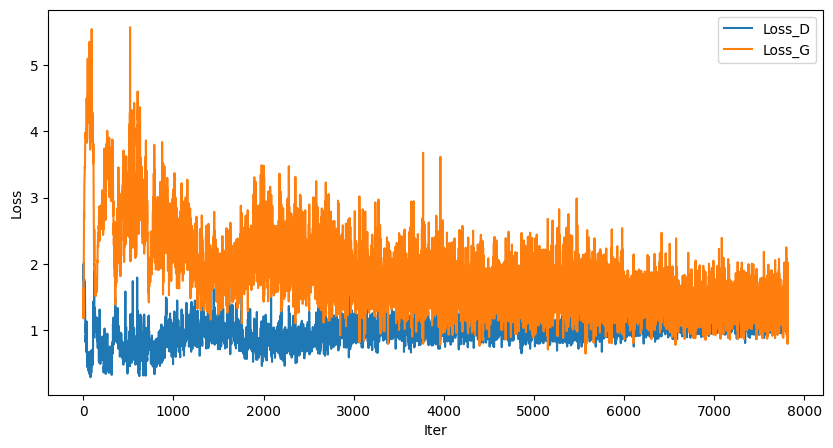

In [14]:
# Устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Гиперпараметры
nz = 100      # Размер латентного вектора
ngf = 64      # Число фильтров в генераторе
ndf = 64      # Число фильтров в дискриминаторе
nc = 3        # Количество каналов (RGB)
lr = 0.0002
beta1 = 0.5
num_epochs = 20
batch_size = 128
ngpu = 2    # Используем 2 GPU (при наличии)


# Инициализация моделей с параметром ngpu
netG = GeneratorDCGAN(nz, ngf, nc, ngpu=ngpu).to(device)
netD = DiscriminatorDCGAN(nc, ndf, ngpu=ngpu).to(device)

# Если доступно более одного GPU, оборачиваем модели в DataParallel
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

epoch_losses_D_DCGAN = []
epoch_losses_G_DCGAN = []
iter_losses_D_DCGAN = []
iter_losses_G_DCGAN = []

# Фиксированный шум для генерации изображений
fixed_noise = torch.randn(64, nz, device=device)

global_iter = 0
for epoch in range(num_epochs):
    running_loss_D = 0.0
    running_loss_G = 0.0
    for i, (data, _) in enumerate(train_loader):
        b_size = data.size(0)
        real_images = data.to(device)
        labels_real = torch.full((b_size,), 1.0, device=device)
        labels_fake = torch.full((b_size,), 0.0, device=device)
        
        # Обучение дискриминатора
        netD.zero_grad()
        output_real = netD(real_images)
        lossD_real = criterion(output_real, labels_real)
        lossD_real.backward()
        
        noise = torch.randn(b_size, nz, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, labels_fake)
        lossD_fake.backward()
        
        lossD = lossD_real + lossD_fake
        optimizerD.step()
        
        # Обучение генератора
        netG.zero_grad()
        output_gen = netD(fake_images)
        lossG = criterion(output_gen, labels_real)
        lossG.backward()
        optimizerG.step()
        
        running_loss_D += lossD.item()
        running_loss_G += lossG.item()
        
        # Сохраняем значения loss для каждой итерации
        iter_losses_D_DCGAN.append(lossD.item())
        iter_losses_G_DCGAN.append(lossG.item())
        global_iter += 1
        
    avg_loss_D = running_loss_D / len(train_loader)
    avg_loss_G = running_loss_G / len(train_loader)
    epoch_losses_D_DCGAN.append(avg_loss_D)
    epoch_losses_G_DCGAN.append(avg_loss_G)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {avg_loss_D:.4f} Loss_G: {avg_loss_G:.4f}")
    

# Построение графика loss по итерациям
plt.figure(figsize=(10,5))
plt.plot(iter_losses_D_DCGAN, label="Loss_D")
plt.plot(iter_losses_G_DCGAN, label="Loss_G")
plt.xlabel("Iter")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Генерация изображений с помощью DCGAN

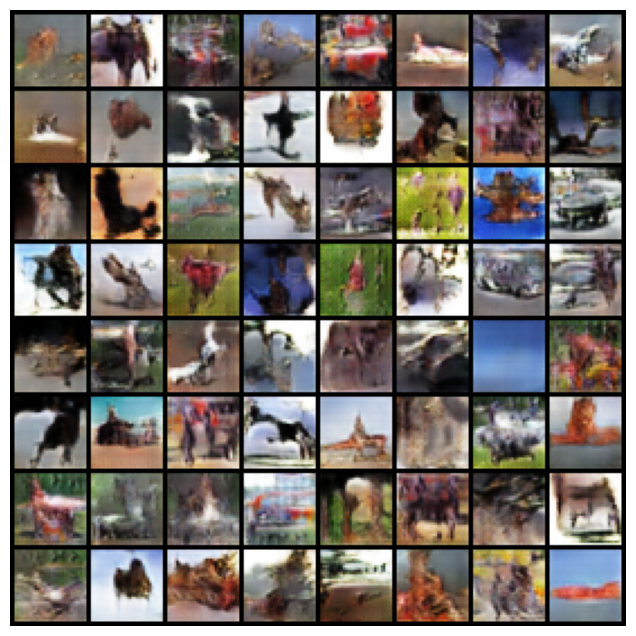

In [17]:
# Переводим модель в режим оценки
netG.eval()

# Генерируем случайный шум: можно использовать новый шум или сохранённый fixed_noise
noise = torch.randn(64, nz, device=device)

# С помощью обученного генератора получаем сгенерированные изображения
with torch.no_grad():
    fake_images = netG(noise).detach().cpu()

# Формируем сетку из изображений для удобной визуализации
grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)

# Отображаем сгенерированные изображения
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()

In [18]:
from torchvision.models import inception_v3
import torch.nn.functional as F


def get_inception_score(images, splits=10):    
    # Изменяем размер изображений до 299x299, как требуется для inception_v3
    up = torch.nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False)
    images_resized = up(images)    
  
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    
    preds = []
    batch_size_inception = 32
    with torch.no_grad():
        for i in range(0, images_resized.size(0), batch_size_inception):
            batch = images_resized[i:i+batch_size_inception].to(device)
            logits = inception_model(batch)
            # Если модель возвращает кортеж, используем первый элемент (логиты)
            if isinstance(logits, tuple):
                logits = logits[0]
            preds.append(F.softmax(logits, dim=1).cpu())
    preds = torch.cat(preds, dim=0)
    
    # Расчёт Inception Score
    scores = []
    N = preds.size(0)
    split_size = N // splits
    for i in range(splits):
        part = preds[i * split_size:(i+1) * split_size, :]
        p_y = torch.mean(part, dim=0, keepdim=True)
        kl_div = part * (torch.log(part) - torch.log(p_y))
        kl_div = torch.mean(torch.sum(kl_div, dim=1))
        scores.append(torch.exp(kl_div).item())
    return np.mean(scores), np.std(scores)

# Для Inception Score необходимо, чтобы изображения были в диапазоне [0, 1]
# Преобразуем сгенерированные изображения из диапазона [-1, 1] в [0, 1]
generated_images_01 = (fake_images + 1) / 2.0

mean_is, std_is = get_inception_score(generated_images_01, splits=10)
print(f"Inception Score: {mean_is:.4f} ± {std_is:.4f}")

Inception Score: 1.9698 ± 0.3142
